In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import get_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)

## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [ ]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100


#### Visualizing data in random sample

waveform:  tensor([[-0.0009, -0.0008, -0.0008,  ...,  0.0007,  0.0003,  0.0004]])
sample_rate:  16000
transcript:  IT WAS GWYNPLAINE'S LAUGH WHICH CREATED THE LAUGHTER OF OTHERS YET HE DID NOT LAUGH HIMSELF
speaker_id:  5895


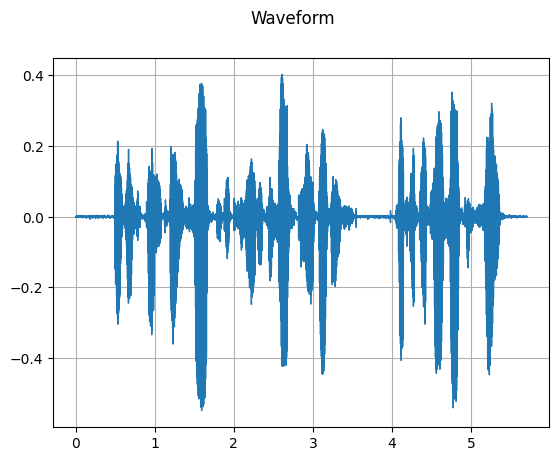

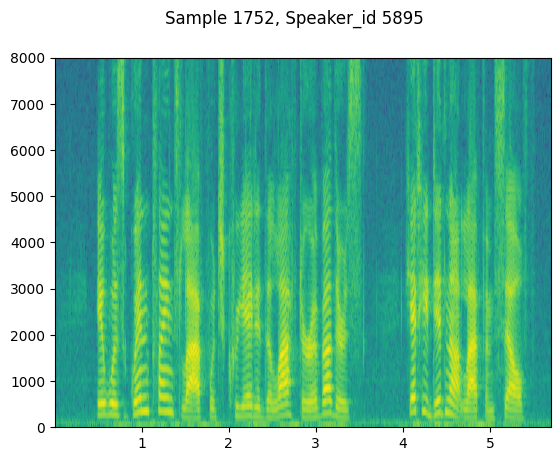

In [3]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []
waveforms = []
transcripts = []

for i in range(dataset.__len__()):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    speaker_ids.append(speaker_id)
    waveforms.append(waveform[0].numpy())
    transcripts.append(transcript)

    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

In [5]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [6]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Number of samples for each speaker

In [7]:
# df_spkr.groupby('speaker_id').size().sort_values()

Dataset has 2703 samples
Random samples has shape: torch.Size([1, 93680])
Unique speaker ids: 40


waveform_lengths  sample_rates  transcript_lengths  audio_durations
min           23120.0       16000.0                 3.0              1.0
std           75130.0           0.0                74.0              5.0
min           23120.0       16000.0                 3.0              1.0
max          522320.0       16000.0               516.0             33.0

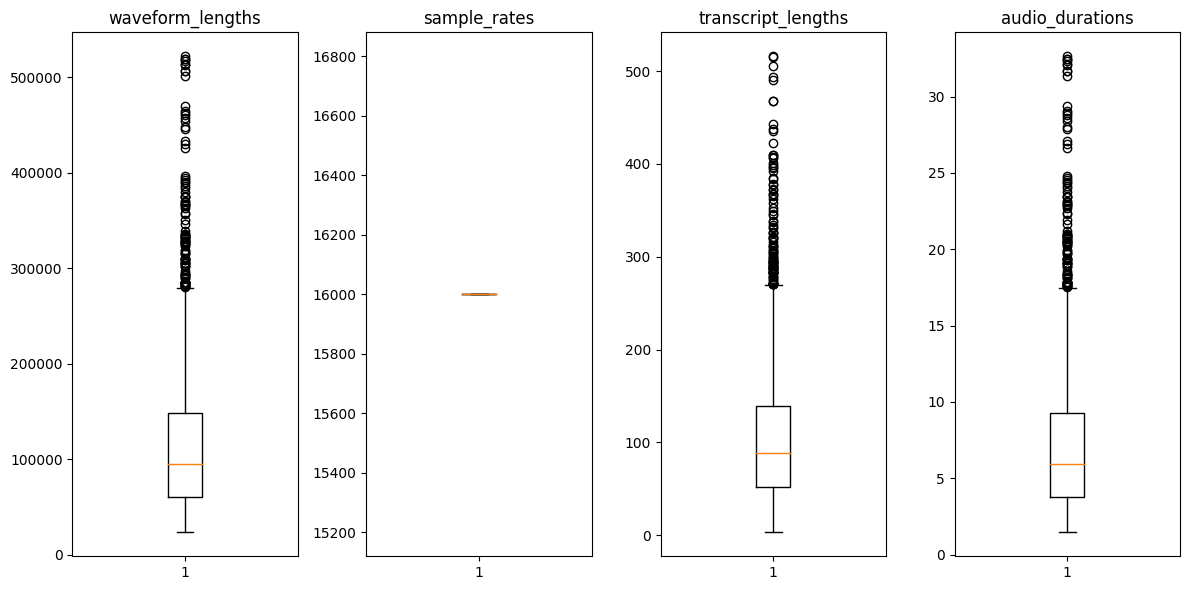

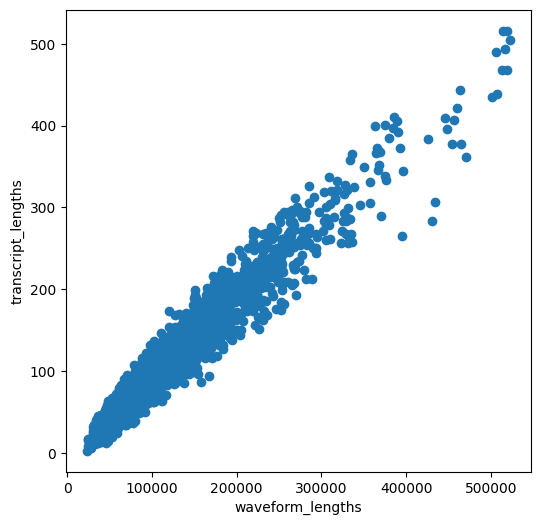

In [8]:
df = calculate_statistics(dataset)

Unique speaker ids

In [9]:
np.unique(df_spkr['speaker_id'])

array([  84,  174,  251,  422,  652,  777, 1272, 1462, 1673, 1919, 1988,
       1993, 2035, 2078, 2086, 2277, 2412, 2428, 2803, 2902, 3000, 3081,
       3170, 3536, 3576, 3752, 3853, 5338, 5536, 5694, 5895, 6241, 6295,
       6313, 6319, 6345, 7850, 7976, 8297, 8842])

Visualize muliple spectrograms

In [10]:
df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
df_speaker_waveform['speaker_id'] = speaker_ids
df_speaker_waveform['waveform'] = waveforms
df_speaker_waveform['transcript'] = transcripts

In [11]:
df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

speaker_id                                           waveform  \
2583          84  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2584          84  [-0.001739502, -0.0017089844, -0.0010375977, -...   
2585          84  [0.0019836426, 0.0021972656, 0.0032043457, 0.0...   
2586          84  [0.0024108887, 0.0023498535, 0.002319336, 0.00...   
2587          84  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             transcript  
2583                                     GO DO YOU HEAR  
2584  BUT IN LESS THAN FIVE MINUTES THE STAIRCASE GR...  
2585  AT THIS MOMENT THE WHOLE SOUL OF THE OLD MAN S...  
2586  AND THE CRY ISSUED FROM HIS PORES IF WE MAY TH...  
2587  D'AVRIGNY RUSHED TOWARDS THE OLD MAN AND MADE ...

/home/renzo/anaconda3/envs/dl-env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7688: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


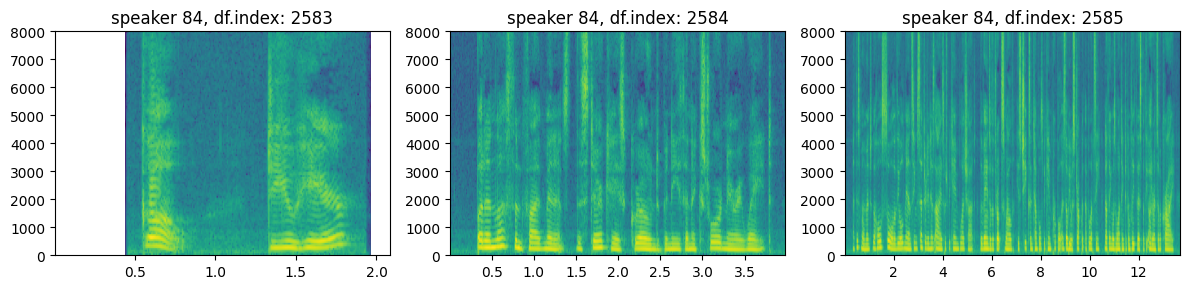

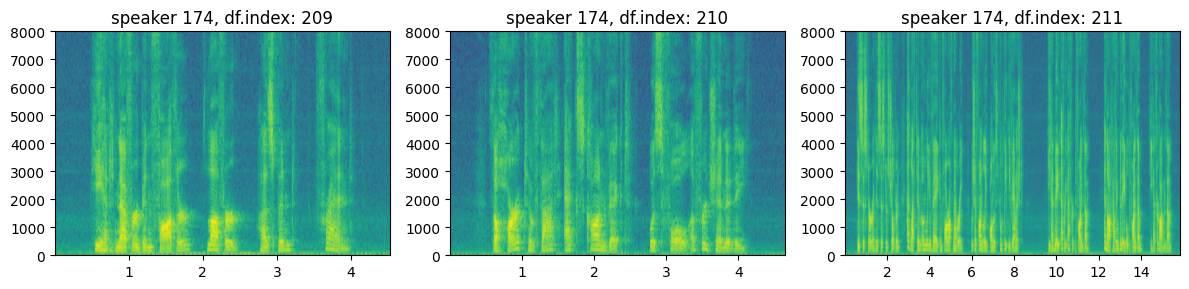

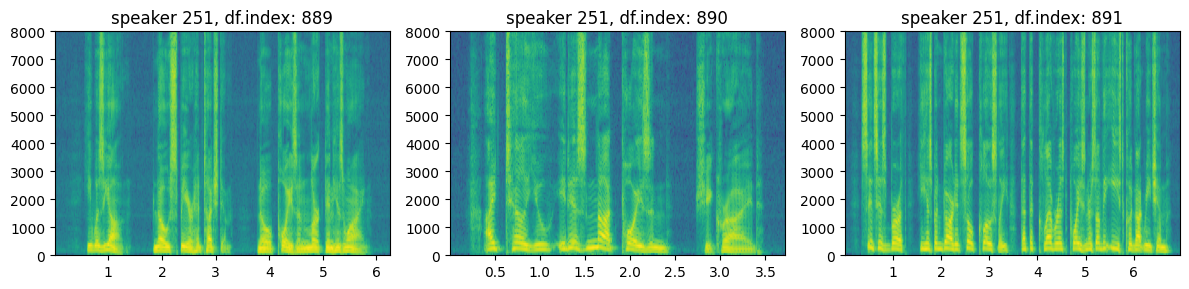

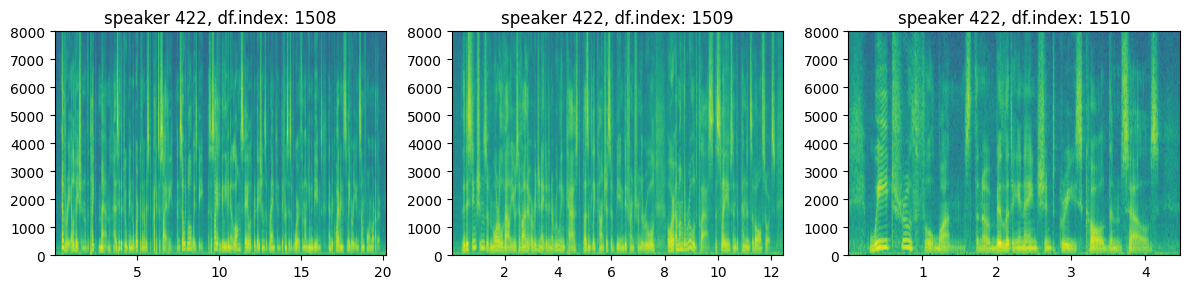

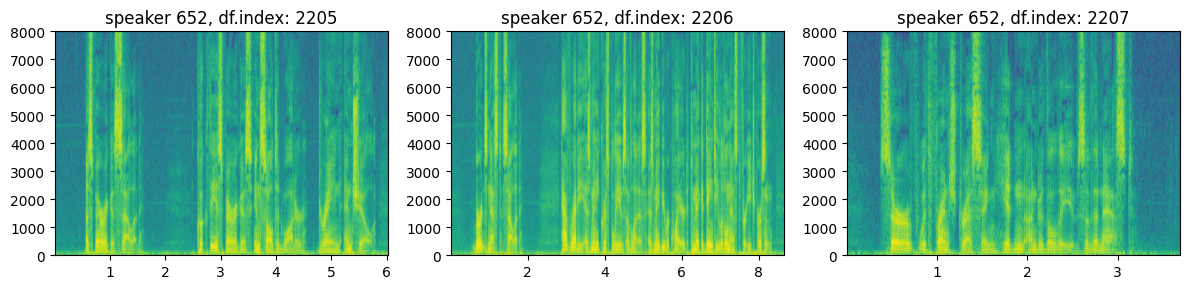

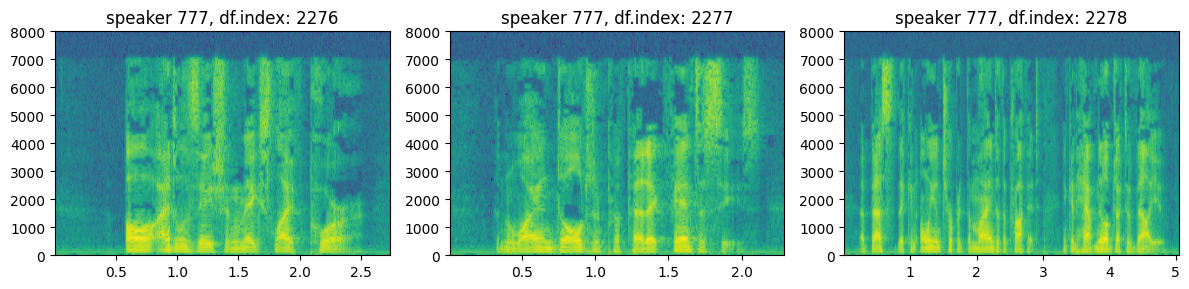

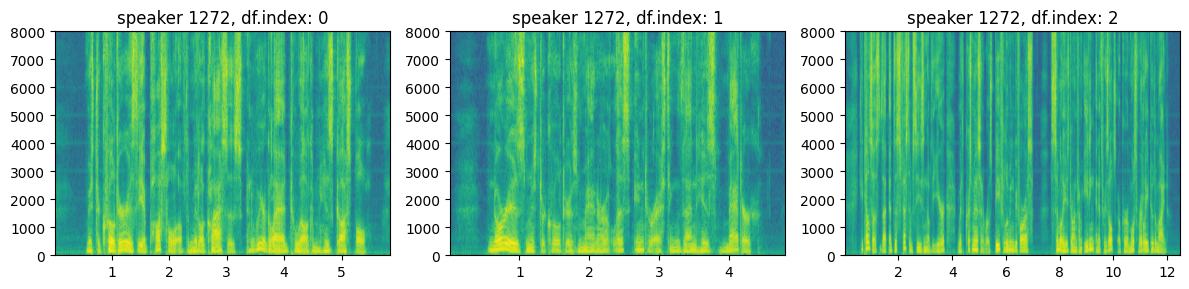

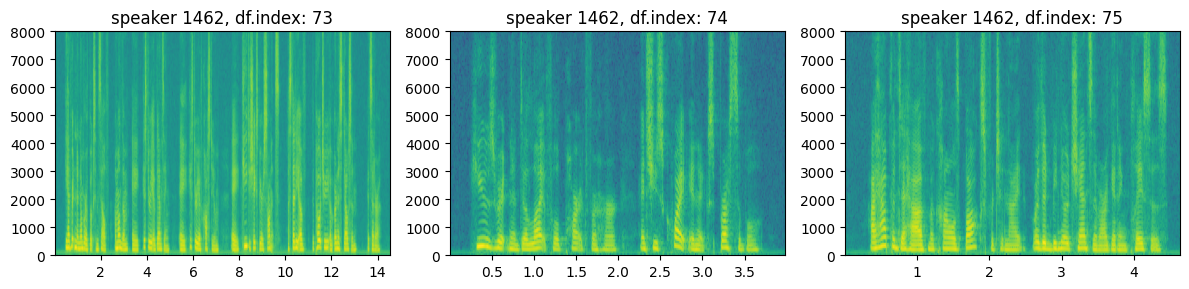

In [12]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        ax[j].specgram(wave, Fs=sample_rate)
        ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

        plt.tight_layout()

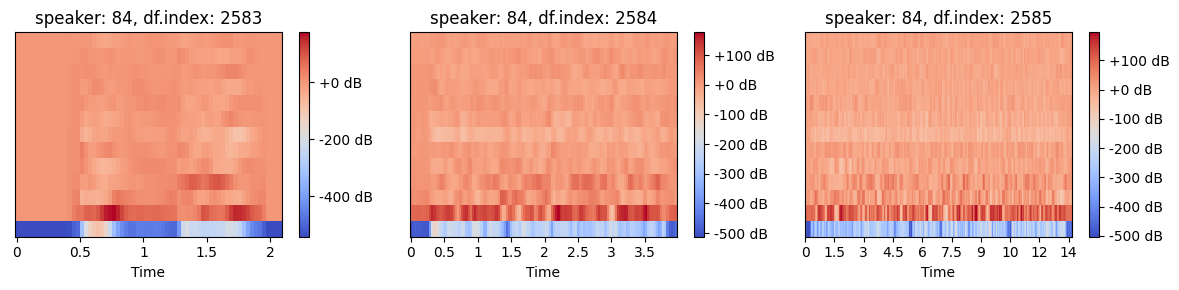

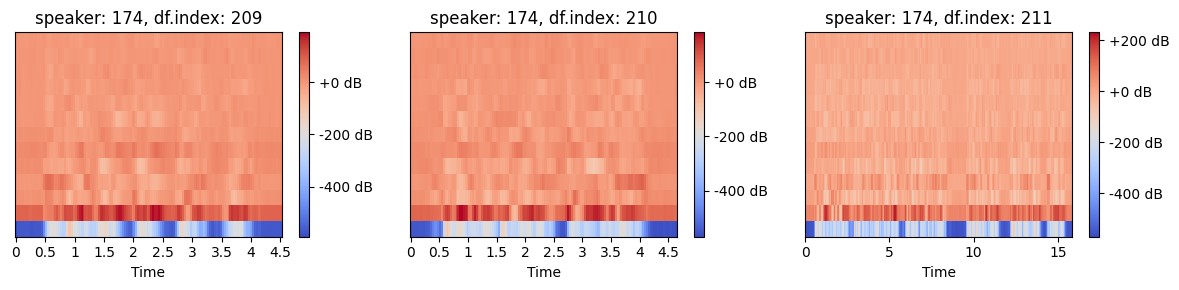

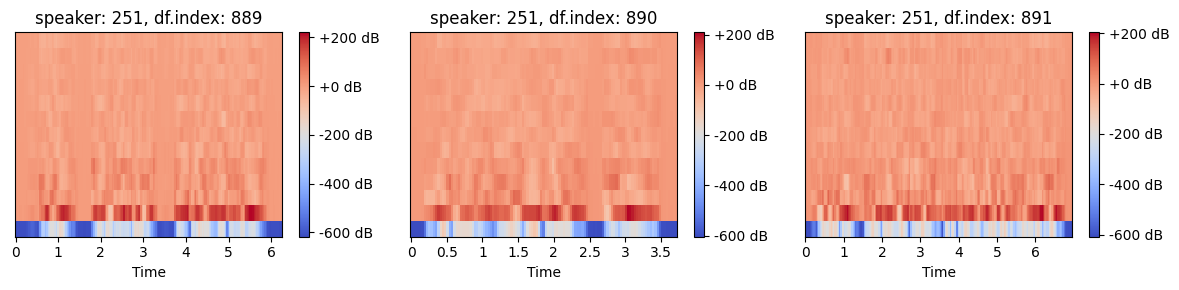

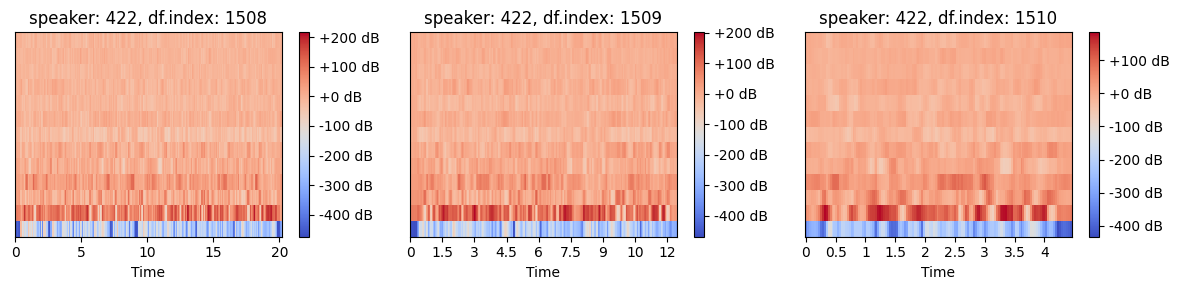

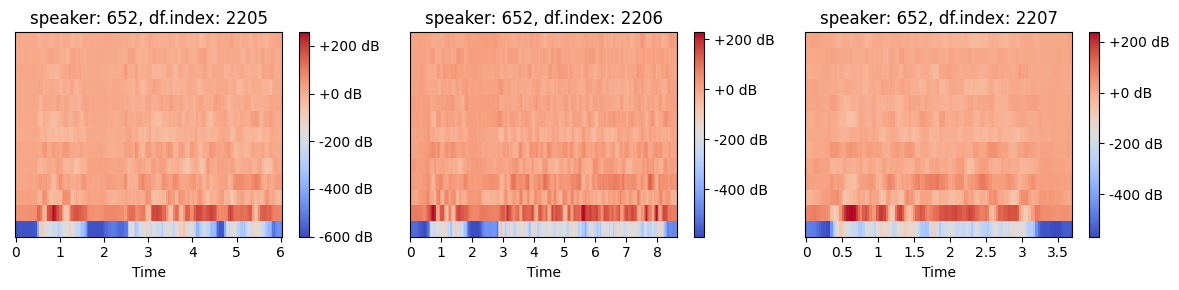

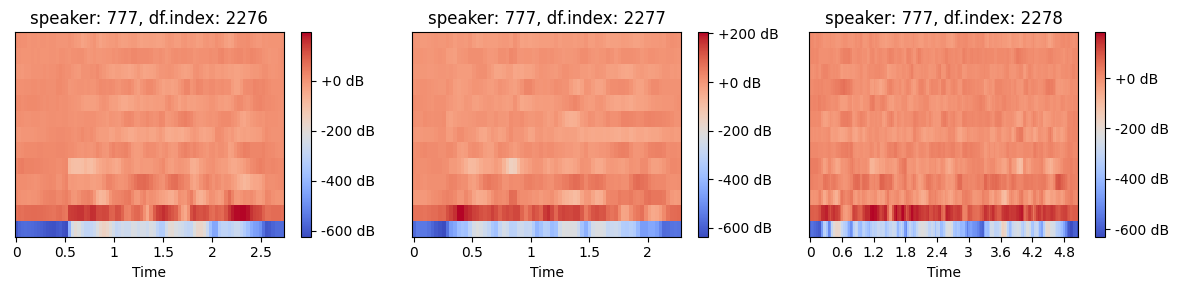

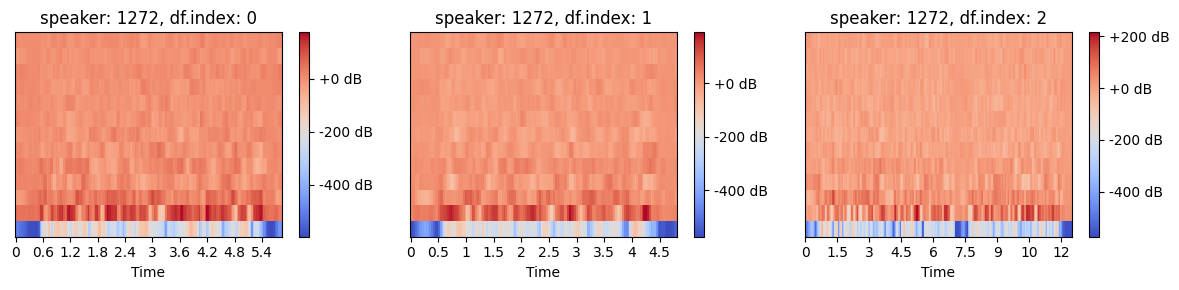

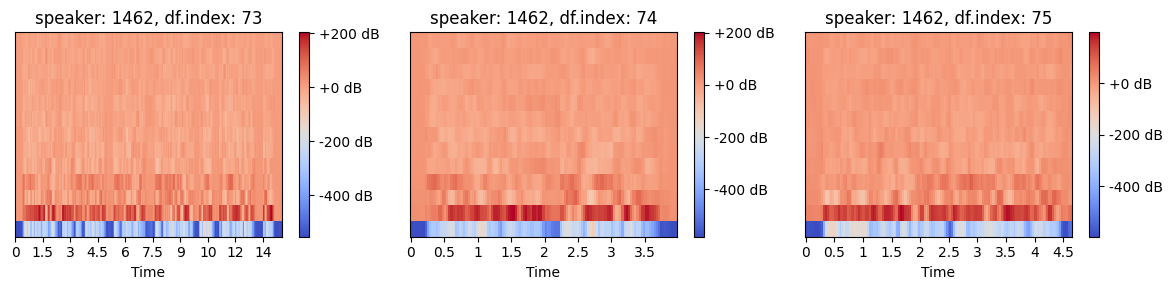

In [13]:
num_cols = 3
for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
    fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
    waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
    idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
    for j, wave in enumerate(waves[:num_cols]):
        mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
        img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
        ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
        fig.colorbar(img, ax=ax[j], format="%+2.f dB")
    plt.tight_layout()

## Preprocessing

In [42]:
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.70
val_pct = 0.20
test_pct = 0.10
number_spectral_coeffients = 13

custom_transform = transforms.Compose([transforms.ToTensor()])

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [43]:
def speaker_encoder(speaker_ids):
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
        
    return speaker_dict

In [45]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

def split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct):
    x = np.asarray(mfcc_dataset.mfcc_speaker_pairs, dtype=object)[:,0]
    y = np.asarray(mfcc_dataset.mfcc_speaker_pairs, dtype=object)[:,1]
    x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=val_pct+test_pct, train_size=train_pct, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=test_pct/(val_pct+test_pct), train_size=val_pct/(val_pct+test_pct), shuffle=True)

    
    train_pairs = [[x_train[i], y_train[i]] for i in range(len(x_train))]
    val_pairs = [[x_val[i], y_val[i]] for i in range(len(x_val))]
    test_pairs = [[x_test[i], y_test[i]] for i in range(len(x_test))]
            
    return train_pairs, val_pairs, test_pairs

class CepstralNormalization:
    def __init__(self, number_spectral_coeffients : int):
        """
        """
        self.number_spectral_coeffients = number_spectral_coeffients
        self.mfcc_dataset = None
        self.mfcc_mean : list[float] | None = None
        self.mfcc_std : list[float] | None = None
    
    def fit(self, mfcc_dataset):
        """
        """
        columns = [f"x_{i}" for i in range(self.number_spectral_coeffients)]
        df_coeffs = pd.DataFrame(columns=columns)

        mfcc_mean = []
        mfcc_std = []

        j = 0
        for mfcc, _ in mfcc_dataset:
            for i in range(self.number_spectral_coeffients):
                df_coeffs.loc[j, f"x_{i}"] = mfcc[i,:]
            j += 1

        for i in range(self.number_spectral_coeffients):
            mfcc_mean.append(np.mean(np.hstack(df_coeffs[f"x_{i}"])))
            mfcc_std.append(np.std(np.hstack(df_coeffs[f"x_{i}"])))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return 
    
    def transform(self, mfcc_dataset):
        """
        """
        mfcc_dataset_copy = copy.deepcopy(mfcc_dataset)
        mfcc_speaker_pairs = np.array(mfcc_dataset_copy.mfcc_speaker_pairs, dtype='object')
        
        for sample in mfcc_speaker_pairs:
            for i in range(13):
                sample[0][i,:] = (sample[0][i,:] - self.mfcc_mean[i]) / self.mfcc_std[i]
        
        mfcc_dataset_copy.mfcc_speaker_pairs = mfcc_speaker_pairs
        
        return mfcc_dataset_copy

class MFCCData(Dataset):
    def __init__(self, dataset, window_size : int, sample_rate : int, speaker_dict : dict):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.dataset = dataset
        self.window_size = window_size        
        self.sample_rate = sample_rate
        self.speaker_dict = speaker_dict
        
        self.transform_to_mfcc()

    def transform_to_mfcc(self):
        """
        Transforms waveforms into MFCC spectrograms
        """
        self.mfcc_speaker_pairs = []
        
        for i in range(self.dataset.__len__()):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = self.dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, self.window_size)
            
            for chunk in splitted_waveform:
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=self.sample_rate)
                self.mfcc_speaker_pairs.append([mfccs, speaker_dict[speaker_id]])
            
    def __len__(self):
        return len(self.mfcc_speaker_pairs)

    def __getitem__(self, idx):
        waveform = self.mfcc_speaker_pairs[idx][0]
        speaker_id = self.mfcc_speaker_pairs[idx][1]
        return waveform, speaker_id

In [46]:
def array_to_image_transform(mfcc_dataset, transform):
    mfcc_dataset = copy.deepcopy(mfcc_dataset)
    for i in range(len(mfcc_dataset.mfcc_speaker_pairs)):
        if transform:
            arr_to_img = Image.fromarray(mfcc_dataset.mfcc_speaker_pairs[i][0], mode='L')
            mfcc_img = transform(arr_to_img)
        else:
            mfcc_img = torch.tensor(mfcc_dataset.mfcc_speaker_pairs[i][0])
        
        if torch.cuda.is_available():
            mfcc_dataset.mfcc_speaker_pairs[i][0] = mfcc_img.to('cuda')
            mfcc_dataset.mfcc_speaker_pairs[i][1] = torch.tensor(mfcc_dataset.mfcc_speaker_pairs[i][1]).to('cuda')
        else:
            mfcc_dataset.mfcc_speaker_pairs[i][0] = mfcc_img
            mfcc_dataset.mfcc_speaker_pairs[i][1] = torch.tensor(mfcc_dataset.mfcc_speaker_pairs[i][1])
    
    return mfcc_dataset

In [47]:
def get_datasets(base_dataset, speaker_dict : dict, window_size : int, sample_rate : int, train_pct : float, val_pct : float, test_pct : float, number_spectral_coeffients : int, normalize=True, transform=None):
    """
    """
    mfcc_dataset = MFCCData(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict)

    train_pairs, val_pairs, test_pairs = split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct)
    mfcc_dataset_train = copy.deepcopy(mfcc_dataset)
    mfcc_dataset_val = copy.deepcopy(mfcc_dataset)
    mfcc_dataset_test = copy.deepcopy(mfcc_dataset)
    mfcc_dataset_train.mfcc_speaker_pairs = train_pairs
    mfcc_dataset_val.mfcc_speaker_pairs = val_pairs
    mfcc_dataset_test.mfcc_speaker_pairs = test_pairs

    if normalize:

        cepstral_normalization = CepstralNormalization(number_spectral_coeffients)

        cepstral_normalization.fit(mfcc_dataset_train)
        mfcc_dataset_train = cepstral_normalization.transform(mfcc_dataset_train)
        mfcc_dataset_val = cepstral_normalization.transform(mfcc_dataset_val)
        mfcc_dataset_test = cepstral_normalization.transform(mfcc_dataset_test)

    mfcc_dataset_train = array_to_image_transform(mfcc_dataset_train, transform)
    mfcc_dataset_val = array_to_image_transform(mfcc_dataset_val, transform)
    mfcc_dataset_test = array_to_image_transform(mfcc_dataset_test, transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [48]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(
                                                            dataset, 
                                                            speaker_dict=speaker_dict,
                                                            window_size=window_size, 
                                                            sample_rate=sample_rate, 
                                                            train_pct=train_pct,
                                                            val_pct=val_pct,
                                                            test_pct=test_pct,
                                                            number_spectral_coeffients=number_spectral_coeffients,
                                                            normalize=True,
                                                            transform=custom_transform,
                                                            )

In [49]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [50]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(2399, 686, 343)

## Model Training

In [51]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    for i, data in enumerate(loader, 0):
        mfcc, speakers = data
        outputs = model(mfcc)
        
        loss = criterion(outputs, speakers)
        total_loss += loss.item()
        total_epoch += len(speakers)
        val_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
        
    loss = float(total_loss) / (i + 1)
    val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(output, mfcc, speakers):
    #select index with maximum prediction score
    correct = 0
    total = 0
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(speakers.view_as(pred)).sum().item()
    total += mfcc.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in range(num_epochs): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        # plt.show()

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(3 * 11 * 124, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.view(-1, 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [106]:
class CNN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 13 * 126, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        x = x.view(-1, 1 * 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [107]:
model = CNN(200, 50, 40)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30

Epoch 0: 
             Train loss 3.690 | Val loss 3.690 
             Train acc 0.027 | Val acc 0.032 

Epoch 2: 
             Train loss 3.683 | Val loss 3.693 
             Train acc 0.029 | Val acc 0.032 

Epoch 4: 
             Train loss 3.682 | Val loss 3.690 
             Train acc 0.028 | Val acc 0.022 

Epoch 6: 
             Train loss 2.844 | Val loss 2.792 
             Train acc 0.183 | Val acc 0.218 

Epoch 8: 
             Train loss 1.733 | Val loss 2.854 
             Train acc 0.472 | Val acc 0.214 

Epoch 10: 
             Train loss 0.760 | Val loss 3.983 
             Train acc 0.749 | Val acc 0.217 

Epoch 12: 
             Train loss 0.298 | Val loss 5.124 
             Train acc 0.902 | Val acc 0.230 

Epoch 14: 
             Train loss 0.227 | Val loss 7.256 
             Train acc 0.924 | Val acc 0.224 

Epoch 16: 
             Train loss 0.072 | Val loss 7.478 
             Train acc 0.974 | Val acc 0.218 

Epoch 18: 
             Train loss 0.011 | Val loss

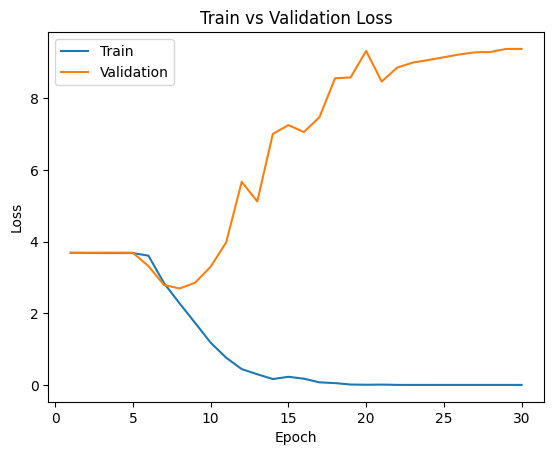

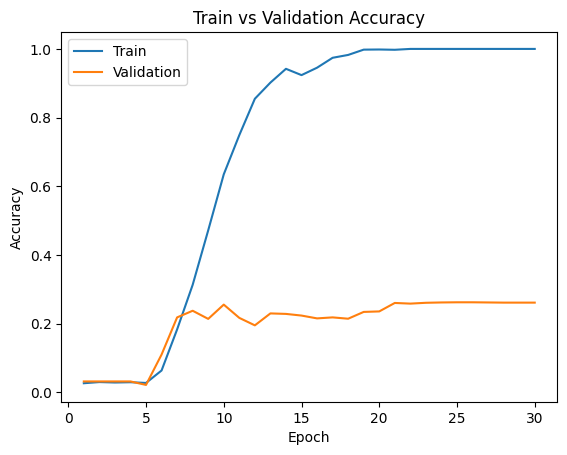

In [108]:
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2)

In [103]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [104]:
test_model(model, test_loader)

Accuracy: 2 %


In [105]:
for mfcc, speakers in test_loader:
    outputs = model(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    print(f"predicted: {predicted}, actual: {speakers}")

predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([ 7, 36,  0, 29, 32, 14, 37,  1, 26, 12], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([22, 25,  6, 11,  1, 21, 31, 28, 11, 11], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([11, 26, 11,  0, 19, 12, 29, 20, 12, 14], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([27, 21, 36, 13, 27, 10,  1, 35, 17,  0], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([13, 13, 22, 20,  8,  4, 28,  3, 33,  4], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([14,  4,  3, 23,  8, 13, 26, 30, 27, 31], device='cuda:0')
predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), actual: tensor([13,  0, 37, 28, 38, 32, 28, 23,  0,  6], device='cuda:0')
predic

In [88]:
for mfcc, speakers in train_loader:
    break

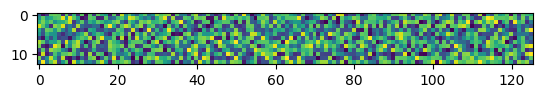

In [89]:
plt.imshow(np.transpose(mfcc[0].to('cpu').numpy(), [1, 2, 0]))

## AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11,11), stride=(4,4), padding=(2,2))

In [ ]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
#Modify the final output layer

alexnet.classifier[6] = nn.Linear(4096, 500)
alexnet.classifier[7] = nn.LeakyReLU()
alexnet.classifier[8] = nn.Linear(500, 40)
alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

In [ ]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(alexnet.parameters())


def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/2399 
        avg_train_acc = train_acc/2399

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/686 
        avg_valid_acc = valid_acc/686

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
import time

In [ ]:
alexnet = alexnet.to('cuda')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 20
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tacc, vacc, tloss, vloss in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


In [ ]:
n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
for mfcc, speakers in train_loader:
    break

In [ ]:
plt.imshow(np.transpose(mfcc[0].to('cpu').numpy(), [1, 2, 0]))